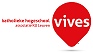<br>


**INTRODUCTION TO ARTIFICIAL INTELLIGENCE**<br>
Andy Louwyck<br>
Stefaan Haspeslagh

---



---



# SLIDING PUZZLE

In deze notebook tonen we hoe we een "sliding puzzle" (https://en.wikipedia.org/wiki/Sliding_puzzle) kunnen modelleren mbv de **state-space representation**.

## **Superklassen `State` en `Move`**

Belangrijke concepten zijn:
- toestand (Engels: state)
- doel (Engels: goal)
- zet (Engels: move)

We definiëren superklassen `State` en `Move` om deze concepten te implementeren.

Klasse `State`:
- methode `calculate_moves`: geeft de zetten die mogelijk zijn vanuit de huidige toestand door toepassen van de productieregels
- methode `apply_move`: past een zet toe op de huidige toestand waardoor we een nieuwe toestand krijgen
- methode `is_goal`: checkt of de huidige toestand een eindtoestand waarmee het doel is bereikt.

In [1]:
from abc import ABC, abstractmethod

class State(ABC):

    @abstractmethod
    def calculate_moves(self):
        # Op een state wordt deze methode aangeroepen om volgens de production rules
        # de moves te berekenen die het probleem in een nieuwe toestand kunnen brengen.
        # Deze functie geeft dus een lijst van moves terug (eventueel leeg).
        pass

    @abstractmethod
    def apply_move(self, move):
        # Op een state kan een move toegepast worden om naar een volgende state over te gaan.
        # Deze functie geeft dus een nieuwe state terug.
        pass
        
    @abstractmethod
    def is_goal(self):
        # Controleert of een state de `goal state` is.
        # Retourneert dus een booleaanse waarde.
        pass

Klasse `Move`
- methode `apply`: past zichzelf (`self`) toe op een gegeven toestand (`state`) 

In [2]:
class Move:
    def __init__(self, state):
        self.state = state
    def apply(self):
        return self.state.apply_move(self)

We gebruiken `pass` in klasse `State` omdat de methodes moeten worden geïmplementeerd door de subklassen. (Men noemt dit een abstracte klasse). 

## **Subklassen `Puzzle` en `Slide`**

Bij de sliding puzzle:
- state: een bepaalde configuratie van de tegeltjes
- move: een tegeltje verschuiven
- goal: bereikt wanneer alle tegeltjes in de juiste volgorde liggen  

Hoe voorstellen?
 - state:
  - de positie van de tegeltjes op het bord
  - n x n matrix, met n = aantal rijen = aantal kolommen
  - alle vakjes zijn genummerd van 0 t.e.m. n²-1, waarbij 0 het lege vakje is
 - move: 
  - een tegeltje verschuiven
  - het lege vakje beweegt 
    - naar links 
    - naar rechts
    - naar boven
    - of naar onder
  - het element 0 in de matrix omwisselen met
    - het element links
    - het element rechts
    - het element boven
    - of het element onder
  - checken of het lege vakje niet aan de rand ligt:
    - element 0 in kolom 0: kan niet wisselen met element links
    - element 0 in kolom n-1: kan niet wisselen met element rechts
    - element 0 in rij 0: kan niet wisselen met element boven
    - element 0 in rij n-1: kan niet wisselen met element onder
  - volgorde links, rechts, boven, onder is conventie die we respecteren!

### Voorbeeld: puzzle met 4 vakjes

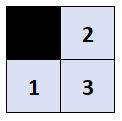

State van het bord voorgesteld adhv een matrix (list van lists):

In [3]:
matrix = [[0, 2], 
          [1, 3]]
matrix

[[0, 2], [1, 3]]

Het lege vakje in de eerste rij en eerste kolom selecteren:

In [4]:
matrix[0][0]  # matrix[rij_index][kolom_index], indices starten bij 0!

0

Tegeltje "1" naar boven schuiven, of dus het lege (zwarte) vakje naar onder brengen, komt neer op het omwisselen van de elementen 0 en 1 in de matrix:

In [5]:
matrix[0][0], matrix[1][0] = matrix[1][0], matrix[0][0]
matrix

[[1, 2], [0, 3]]

### NumPy array

- NumPy array gebruiken om positie van tegeltjes bij te houden
- Voordeel: we kunnen matrixbewerkingen gebruiken!

In [6]:
import numpy as np

matrix = np.array(matrix)
matrix

ModuleNotFoundError: No module named 'numpy'

In [ ]:
matrix[0, 0]  # vakje bovenaan links

In [ ]:
irow, icol = np.where(matrix == 0)  # positie van lege vakje
irow[0], icol[0]

In [ ]:
matrix[1, 0], matrix[1, 1] = matrix[1, 1], matrix[1, 0]  # lege vakje naar rechts verschuiven
matrix

### Klasse `Slide`

- Zwarte vakje `(irow, icol)` naar links, rechts, omhoog of omlaag bewegen:
  - links: `icol_new = icol - 1`
  - rechts: `icol_new = icol + 1`
  - omhoog: `irow_new = irow - 1`
  - omlaag: `irow_new = irow + 1`
- Erft van superklasse `Move`

In [ ]:
import numpy as np

class Slide(Move):
    
    # constructor
    def __init__(self, state, drow=0, dcol=0):
        super().__init__(state)
        self.drow = drow
        self.dcol = dcol
    
    # checkt of slide geldig is, rekening houdend met de randen van de puzzle
    @abstractmethod
    def is_valid(self):
        pass
    
    # berekent de nieuwe positiematrix
    def new_matrix(self):
        if self.is_valid():
            irow1, icol1 = self.state.empty  # (irow, icol) van lege vakje
            irow2, icol2 = irow1 + self.drow, icol1 + self.dcol  # (irow, icol) van vakje waarmee gewisseld wordt
            new_matrix = self.state.matrix.copy()
            new_matrix[irow1,icol1], new_matrix[irow2,icol2] = new_matrix[irow2,icol2], new_matrix[irow1,icol1]
            return new_matrix    
    
    # string representatie object
    def __repr__(self):
        if self.dcol == -1:
            return 'L'
        elif self.dcol == 1:
            return 'R'
        elif self.drow == -1:
            return 'U'
        elif self.drow == 1:
            return 'D'

Subklassen creëren voor elke move afzonderlijk:

In [ ]:
class Left(Slide):
    def __init__(self, state):
        super().__init__(state, dcol=-1)
    def is_valid(self):
        return self.state.empty[1] > 0

class Right(Slide):
    def __init__(self, state):
        super().__init__(state, dcol=1)
    def is_valid(self):
        return self.state.empty[1] < self.state.size - 1

class Up(Slide):
    def __init__(self, state):
        super().__init__(state, drow=-1)
    def is_valid(self):
        return self.state.empty[0] > 0

class Down(Slide):
    def __init__(self, state):
        super().__init__(state, drow=1)    
    def is_valid(self):
        return self.state.empty[0] < self.state.size - 1

### Klasse `Puzzle`

- Klasse voor de toestand:
  - bevat de matrix met de positie van de tegeltjes
  - bevat ook de vorige toestanden (hoewel niet nodig om toestand te definiëren)
- Erft van superklasse `State`

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import clear_output
from time import sleep

class Puzzle(State):

    # constructor
    def __init__(self, matrix, previous=[]):
        self.matrix = np.array(matrix)  # matrix omzetten naar NumPy array
        self.size = len(matrix)  # aantal rijen = aantal kolommen
        self.empty = np.where(self.matrix == 0)  # (irow, icol) van lege vakje
        self.previous = previous  # vorige states
        
    # berekent de mogelijke posities van het zwarte vakje
    def calculate_moves(self):
        moves = [Left(self), Right(self), Up(self), Down(self)]
        return [move for move in moves if move.is_valid()]
        
    # verschuift het zwarte vakje en retourneert nieuwe state
    def apply_move(self, move):
        return Puzzle(move.new_matrix(), self.previous + [self])

    # checkt of alle vakjes in de juiste volgorde liggen    
    def is_goal(self):
        goal = np.arange(1, self.size**2 + 1)
        goal[-1] = 0  # goal is de matrix met alle cijfers in de juiste volgorde (en nul op het einde)
        return np.all(self.matrix.flatten() == goal)
    
    # plot matrix    
    def plot(self):
        cmap = colors.ListedColormap(['black', 'lightblue'])
        norm = colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)
        grid = self.matrix.copy()
        grid[grid>0] = 1
        fig, ax = plt.subplots(1, 1)
        ax.matshow(grid, cmap=cmap, norm=norm)
        xx = np.arange(0, self.size)
        xx, yy = np.meshgrid(xx, xx)
        xx = xx.flatten()
        yy = yy.flatten()
        b = (grid > 0).flatten()
        matrix = self.matrix.flatten()
        font = dict(weight='bold', size=40)
        for x, y, i in zip(xx[b], yy[b], matrix[b]):
            ax.text(x, y, i, ha="center", va="center", fontdict=font)
        ax.set_aspect("equal")
        ticks = np.linspace(-0.5, self.size - 0.5, self.size + 1)
        ax.set_xticks(ticks)
        ax.set_xticklabels([])
        ax.set_yticks(ticks)
        ax.set_yticklabels([])
        ax.tick_params(axis=u'both', which=u'both', length=0)
        ax.grid(linewidth=3, color="white")
        ax.set_xlim((ticks[0], ticks[-1]))
        ax.set_ylim((ticks[-1], ticks[0]))
        plt.show()

    # plot opeenvolgende posities
    def plot_moves(self, wait=1):
        for puzzle in self.previous + [self]:
            clear_output()
            puzzle.plot()
            sleep(wait)
          
    # omzetten naar string
    def __repr__(self):
        return "\n".join([" ".join(map(str, row)) for row in self.matrix]).replace("0", '.')

    # 2 objecten zijn gelijk als hun matrices gelijk zijn
    def __eq__(self, other):
        return np.all(self.matrix == other.matrix)

### Voorbeeld: Puzzle met 4 vakjes

In [ ]:
p1 = Puzzle(matrix)
p1

In [ ]:
p1.plot()

In [ ]:
p1.is_goal()

In [ ]:
p2 = Puzzle([[1, 2], [3, 0]])
p2

In [ ]:
p2.plot()

In [ ]:
p2.is_goal()

In [ ]:
p1 == p2

In [ ]:
moves1 = p1.calculate_moves()
moves1

In [ ]:
p3 = p1.apply_move(moves1[0])
p3.plot()


In [ ]:
p2 == p3

In [ ]:
p3.previous

In [ ]:
moves3 = p3.calculate_moves()
moves3

In [ ]:
p4 = p3.apply_move(moves3[-1])
p4

In [ ]:
for puzzle in p4.previous:
    print(puzzle)
    print()

In [ ]:
p4.plot_moves()

### Klassendiagram

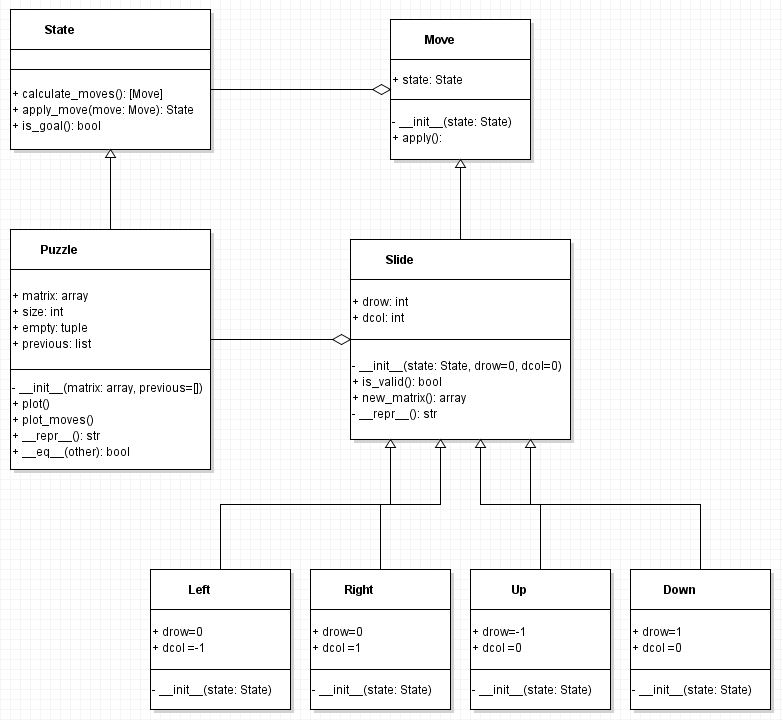